# Imports and settings

In [293]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from scipy import stats
from sklearn.impute import SimpleImputer


In [294]:
pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns',100)

In [295]:
#Importing data
train_a = pd.read_parquet('A/train_targets.parquet')
train_b = pd.read_parquet('B/train_targets.parquet')
train_c = pd.read_parquet('C/train_targets.parquet')

X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('C/X_train_estimated.parquet')

X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')

X_test_estimated_a = pd.read_parquet('A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('C/X_test_estimated.parquet')

# Labeling data
train_a['building_id'] = 'a'
train_b['building_id'] = 'b'
train_c['building_id'] = 'c'

X_train_estimated_a['building_id'] = 'a'
X_train_estimated_b['building_id'] = 'b'
X_train_estimated_c['building_id'] = 'c'

X_train_observed_a['building_id'] = 'a'
X_train_observed_b['building_id'] = 'b'
X_train_observed_c['building_id'] = 'c'

X_test_estimated_a['building_id'] = 'a'
X_test_estimated_b['building_id'] = 'b'
X_test_estimated_c['building_id'] = 'c'

# Combining data
all_observed_X = pd.concat([X_train_observed_a,X_train_observed_b,X_train_observed_c])
all_estimated_X = pd.concat([X_train_estimated_a,X_train_estimated_b,X_train_estimated_c])
all_y = pd.concat([train_a, train_b, train_c])
X_test = pd.concat([X_test_estimated_a,X_test_estimated_b,X_test_estimated_c])

# add type of weather data
all_observed_X['isObserved'] = 1
all_estimated_X['isObserved'] = 0
X_test['isObserved'] = 0

# Combining training data
all_X = pd.concat([all_observed_X,all_estimated_X])

# Aggregating all_X
all_X_aggregated = all_X.copy()
all_X_aggregated['time_hour'] = all_X_aggregated['date_forecast'].dt.floor('H')
all_X_aggregated = all_X_aggregated.groupby(['building_id','time_hour','isObserved']).mean().reset_index()

# Aggregating X_test
X_test_aggregated = X_test.copy()
X_test_aggregated['time_hour'] = X_test_aggregated['date_forecast'].dt.floor('H')
X_test_aggregated = X_test_aggregated.groupby(['building_id','time_hour','isObserved']).mean().reset_index()

# Renaming time column in all_y
all_y = all_y.rename(columns={'time': 'time_hour'})

# Merging all_X_aggregated and all_y
all_train = pd.merge(all_X_aggregated,all_y,on=['building_id','time_hour'],how='inner') # right join to keep all y values


In [296]:
all_train.head()

,building_id,time_hour,isObserved,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,date_calc,pv_measurement
0,a,2019-06-02 22:00:00,1,2019-06-02 22:22:30,7.700,1.22825,1728.949951,0.000000,0.00,1728.949951,0.0,280.299988,0.000,0.000000,0.00,0.000000,99.074997,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1006.299988,0.0,0.0,993.750000,999.775024,0.0,0.000,71.674995,1005.799988,NaN,0.0,0.0,0.0,0.175,348.036743,-3.77425,0.0,286.225006,100.000000,40386.476562,3.600,-3.575,-0.500,0.0,NaT,0.00
1,a,2019-06-02 23:00:00,1,2019-06-02 23:22:30,7.700,1.22350,1689.824951,0.000000,0.00,1689.824951,0.0,280.299988,0.000,0.000000,0.00,0.000000,99.750000,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1005.200012,0.0,0.0,992.674988,998.650024,0.0,0.025,68.000000,1004.650024,NaN,0.0,0.0,0.0,0.200,91.980751,-4.35725,0.0,286.899994,100.000000,33770.648438,3.350,-3.350,0.275,0.0,NaT,0.00
2,a,2019-06-03 00:00:00,1,2019-06-03 00:22:30,7.875,1.21975,1563.224976,0.000000,0.00,1563.224976,0.0,280.649994,0.000,0.000000,0.00,0.000000,100.000000,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1004.525024,0.0,0.0,992.000000,997.974976,0.0,0.100,67.949997,1003.950012,NaN,0.0,0.0,0.0,0.400,14.934750,-3.30950,0.0,286.950012,100.000000,13595.500000,3.050,-2.950,0.750,0.0,NaT,0.00
3,a,2019-06-03 01:00:00,1,2019-06-03 01:22:30,8.425,1.21800,1283.425049,208.649994,0.75,1283.425049,0.0,281.674988,0.300,526.775024,0.00,0.000000,100.000000,6.0,0.0,0.0,0.0,0.0,0.0,0.25,1.0,1004.025024,0.0,0.0,991.500000,997.449951,0.0,0.125,73.875000,1003.449951,NaN,0.0,0.0,0.0,0.550,28.630251,-0.82250,0.0,286.750000,100.000000,2321.850098,2.725,-2.600,0.875,0.0,NaT,0.00
4,a,2019-06-03 02:00:00,1,2019-06-03 02:22:30,8.950,1.21800,1003.500000,32468.150391,23.10,1003.500000,0.0,282.500000,11.975,22068.949219,0.15,282.975006,84.875000,6.0,0.0,0.0,0.0,0.0,0.0,1.00,0.0,1003.099976,0.0,0.0,990.550049,996.500000,0.0,0.100,79.925003,1002.500000,NaN,0.0,0.0,0.0,0.250,41.997501,3.05125,0.0,286.450012,99.224998,11634.799805,2.550,-2.350,0.925,0.0,NaT,19.36


In [297]:

#all_train = all_train[all_train.pv_measurement.notnull()]
all_train = all_train.dropna(subset=['pv_measurement'], axis=0)


In [298]:
# imputing
features = [
    'cloud_base_agl:m',
    'ceiling_height_agl:m'
]


# create the imputer object with mean strategy
imputer = SimpleImputer(strategy='mean')

# fit and transform the imputer on the selected features
all_train[features] = imputer.fit_transform(all_train[features])



In [299]:
all_train.isna().sum()


building_id                           0
time_hour                             0
isObserved                            0
date_forecast                         0
absolute_humidity_2m:gm3              0
air_density_2m:kgm3                   0
ceiling_height_agl:m                  0
clear_sky_energy_1h:J                 0
clear_sky_rad:W                       0
cloud_base_agl:m                      0
dew_or_rime:idx                       0
dew_point_2m:K                        0
diffuse_rad:W                         0
diffuse_rad_1h:J                      0
direct_rad:W                          0
direct_rad_1h:J                       0
effective_cloud_cover:p               0
elevation:m                           0
fresh_snow_12h:cm                     0
fresh_snow_1h:cm                      0
fresh_snow_24h:cm                     0
fresh_snow_3h:cm                      0
fresh_snow_6h:cm                      0
is_day:idx                            0
is_in_shadow:idx                      0


In [300]:
# one hot encoding
features = [
    'building_id'
]

# one hot encoding for categorical features
ohe_enc = OneHotEncoder()

X_cat = all_train[['building_id']]

X_cat = pd.DataFrame(ohe_enc.fit_transform(X_cat).toarray())
X_cat.columns = ['building_id_a','building_id_b','building_id_c']


X = pd.concat([all_train.reset_index(drop=True), X_cat.reset_index(drop=True)], axis=1).drop(columns=['building_id'])
X.columns = X.columns.map(str)


X.tail()

,time_hour,isObserved,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,date_calc,pv_measurement,building_id_a,building_id_b,building_id_c
92946,2023-04-30 19:00:00,0,2023-04-30 19:22:30,4.4,1.27550,1456.574951,84010.148438,4.175,551.224976,0.0,272.024994,2.775,54774.000000,0.0,9934.575195,97.724998,24.0,0.0,0.0,0.3,0.0,0.0,0.5,1.0,1014.900024,0.0,0.0,999.049988,1005.275024,0.0,0.0,74.800003,1011.525024,NaN,0.0,0.0,0.0,0.000,304.936493,-0.2015,0.000,274.924988,97.724998,25028.000000,4.075,3.600,1.875,0.0,2023-04-29 07:00:05,50.96,0.0,0.0,1.0
92947,2023-04-30 20:00:00,0,2023-04-30 20:22:30,4.4,1.27850,1476.349976,2206.800049,0.000,564.099976,0.0,271.950012,0.000,4984.049805,0.0,0.000000,95.449997,24.0,0.0,0.0,0.3,0.0,0.0,0.0,1.0,1014.849976,0.0,0.0,999.025024,1005.250000,0.0,0.0,76.974998,1011.549988,NaN,0.0,0.0,0.0,0.000,318.620483,-5.2040,0.000,274.575012,95.850006,23995.599609,3.600,2.950,2.125,0.0,2023-04-29 07:00:05,2.94,0.0,0.0,1.0
92948,2023-04-30 21:00:00,0,2023-04-30 21:22:30,4.4,1.27900,1516.300049,0.000000,0.000,578.700012,0.0,271.899994,0.000,0.000000,0.0,0.000000,93.925003,24.0,0.0,0.0,0.3,0.0,0.0,0.0,1.0,1014.650024,0.0,0.0,998.900024,1005.125000,0.0,0.0,77.724998,1011.400024,NaN,0.0,0.0,0.0,0.000,332.780243,-8.9845,0.025,274.399994,95.925003,23068.599609,3.600,2.625,2.400,0.0,2023-04-29 07:00:05,0.00,0.0,0.0,1.0
92949,2023-04-30 22:00:00,0,2023-04-30 22:22:30,4.4,1.27975,1240.599976,0.000000,0.000,551.500000,0.0,271.950012,0.000,0.000000,0.0,0.000000,98.375000,24.0,0.0,0.0,0.3,0.0,0.0,0.0,1.0,1014.500000,0.0,0.0,998.724976,1004.974976,0.0,0.0,79.400002,1011.224976,NaN,0.0,0.0,0.0,0.075,347.373230,-11.2705,0.125,274.225006,99.425003,11856.700195,3.275,2.325,2.325,0.0,2023-04-29 07:00:05,-0.00,0.0,0.0,1.0
92950,2023-04-30 23:00:00,0,2023-04-30 23:22:30,4.4,1.27975,1484.500000,0.000000,0.000,558.674988,0.0,271.950012,0.000,0.000000,0.0,0.000000,99.099998,24.0,0.0,0.0,0.3,0.0,0.0,0.0,1.0,1014.150024,0.0,0.0,998.325012,1004.599976,0.0,0.0,79.949997,1010.849976,NaN,0.0,0.0,0.0,0.075,92.206505,-11.8800,0.125,274.175018,99.875000,11125.900391,2.925,1.925,2.225,0.0,2023-04-29 07:00:05,-0.00,0.0,0.0,1.0


In [301]:
X.isna().sum()


time_hour                             0
isObserved                            0
date_forecast                         0
absolute_humidity_2m:gm3              0
air_density_2m:kgm3                   0
ceiling_height_agl:m                  0
clear_sky_energy_1h:J                 0
clear_sky_rad:W                       0
cloud_base_agl:m                      0
dew_or_rime:idx                       0
dew_point_2m:K                        0
diffuse_rad:W                         0
diffuse_rad_1h:J                      0
direct_rad:W                          0
direct_rad_1h:J                       0
effective_cloud_cover:p               0
elevation:m                           0
fresh_snow_12h:cm                     0
fresh_snow_1h:cm                      0
fresh_snow_24h:cm                     0
fresh_snow_3h:cm                      0
fresh_snow_6h:cm                      0
is_day:idx                            0
is_in_shadow:idx                      0
msl_pressure:hPa                      0


In [302]:
# delete columns
features = ['date_calc', 'snow_density:kgm3', 'elevation:m', 'time_hour', 'date_forecast']
target = ['pv_measurement']
y = all_train[target]
X = X.drop(features+target,axis=1)

In [303]:
cutoff = int(len(X)*0.8)

X_train = X[:cutoff]
X_val = X[cutoff:]
y_train = y[:cutoff]
y_val = y[cutoff:]



from sklearn.ensemble import RandomForestRegressor
random_forest = RandomForestRegressor(n_estimators=20, random_state=42)

random_forest.fit(X_train, y_train)


print(f'score without pca: {random_forest.score(X_val, y_val)}')

/var/folders/s_/tyyjfphn3wl93jz8bhkrh3x40000gn/T/ipykernel_89994/2036850782.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest.fit(X_train, y_train)


score without pca: 0.8387528678973553


In [304]:
from sklearn.metrics import mean_absolute_error
y_pred = random_forest.predict(X_val)

# calculate the mean squared error
mse = mean_absolute_error(y_val, y_pred)
mse

26.866658377313982

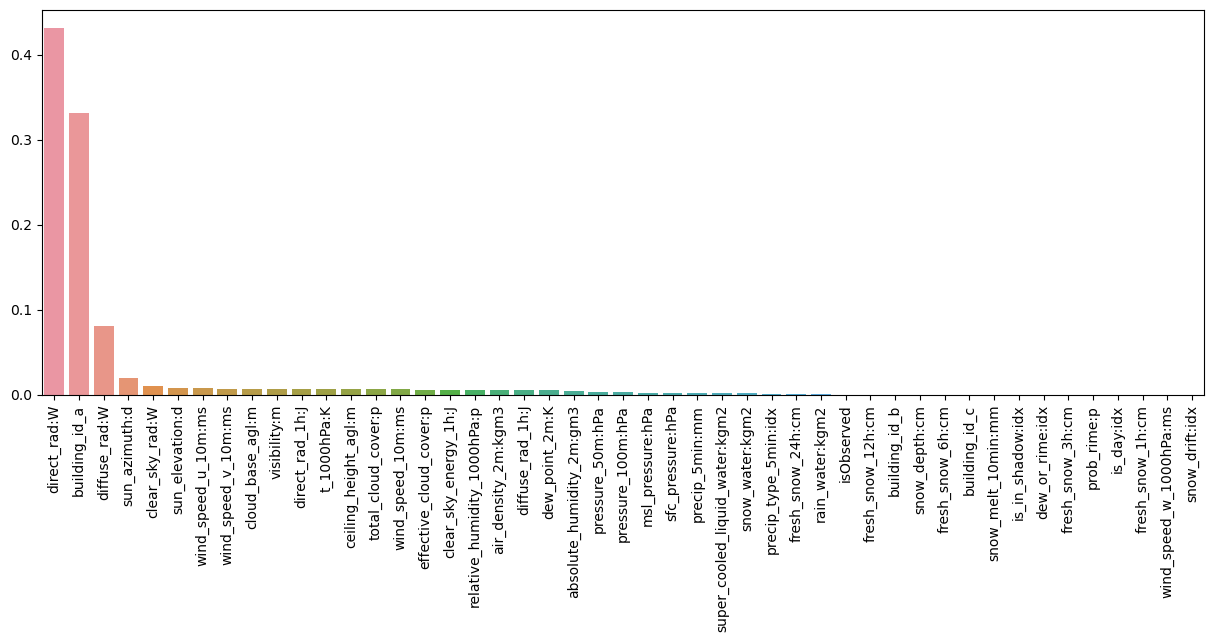

In [305]:
f = pd.Series(random_forest.feature_importances_,index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(15,5))
plt.xticks(rotation=90)
sns.barplot(x=f.index, y=f)

# save the figure to the graphs folder
plt.savefig('graphs/feature_importances.png')


In [306]:
def pca_analysis(df, features, feature_prefix, n_components, scalers):
    df = df.copy(deep=True)

    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df[features])

    pca_transformer = PCA(n_components=n_components)
    df_pca = pd.DataFrame(pca_transformer.fit_transform(df_scaled))
    df_pca.columns = [feature_prefix + "_" +
                      str(i+1) for i in range(n_components)]

    df = df.drop(features, axis=1)
    # df = pd.concat([df, df_pca], axis=1, ignore_index=True)
    df = pd.concat([df, pd.DataFrame(df_pca)], axis=1)

    scalers |= {feature_prefix: {'scaler': scaler,
                                 'pca_transformer': pca_transformer}}

    return df, scalers

sun_features_list = ['clear_sky_energy_1h:J', 'clear_sky_rad:W', 'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J', 'is_day:idx', 'is_in_shadow:idx', 'sun_elevation:d']

humidity_features_list = ['absolute_humidity_2m:gm3', 'air_density_2m:kgm3', 'dew_point_2m:K', 't_1000hPa:K']

snow_features_list = ['fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm', 'fresh_snow_6h:cm']

cloud_height_features_list = ['ceiling_height_agl:m', 'cloud_base_agl:m']

all_groups = [sun_features_list, humidity_features_list,
              snow_features_list, cloud_height_features_list]
all_groups_names = ['sun', 'humidity', 'snow', 'cloud_height']
n_pca = [2, 2, 1, 1]

all_data_pca = X_train.copy()
all_data_pca_val = X_val.copy()

scalers = {}

for group, name, n in zip(all_groups, all_groups_names, n_pca):
    all_data_pca, scalers = pca_analysis(all_data_pca, group, name, n, scalers)

for group, name, n in zip(all_groups, all_groups_names, n_pca):
    all_data_pca_val, scalers = pca_analysis(all_data_pca_val, group, name, n, scalers)
    


ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
random_forest = RandomForestRegressor(n_estimators=20, random_state=42)

random_forest.fit(all_data_pca, y_train)




/var/folders/s_/tyyjfphn3wl93jz8bhkrh3x40000gn/T/ipykernel_89994/62466816.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest.fit(all_data_pca, y_train)


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- absolute_humidity_2m:gm3
- air_density_2m:kgm3
- ceiling_height_agl:m
- clear_sky_energy_1h:J
- clear_sky_rad:W
- ...
Feature names seen at fit time, yet now missing:
- cloud_height_1
- humidity_1
- humidity_2
- snow_1
- sun_1
- ...


In [ ]:
y_pred = random_forest.predict(X_val)

# calculate the mean squared error
mse = mean_absolute_error(y_val, y_pred)
mse


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- absolute_humidity_2m:gm3
- air_density_2m:kgm3
- ceiling_height_agl:m
- clear_sky_energy_1h:J
- clear_sky_rad:W
- ...
Feature names seen at fit time, yet now missing:
- cloud_height_1
- humidity_1
- humidity_2
- snow_1
- sun_1
- ...


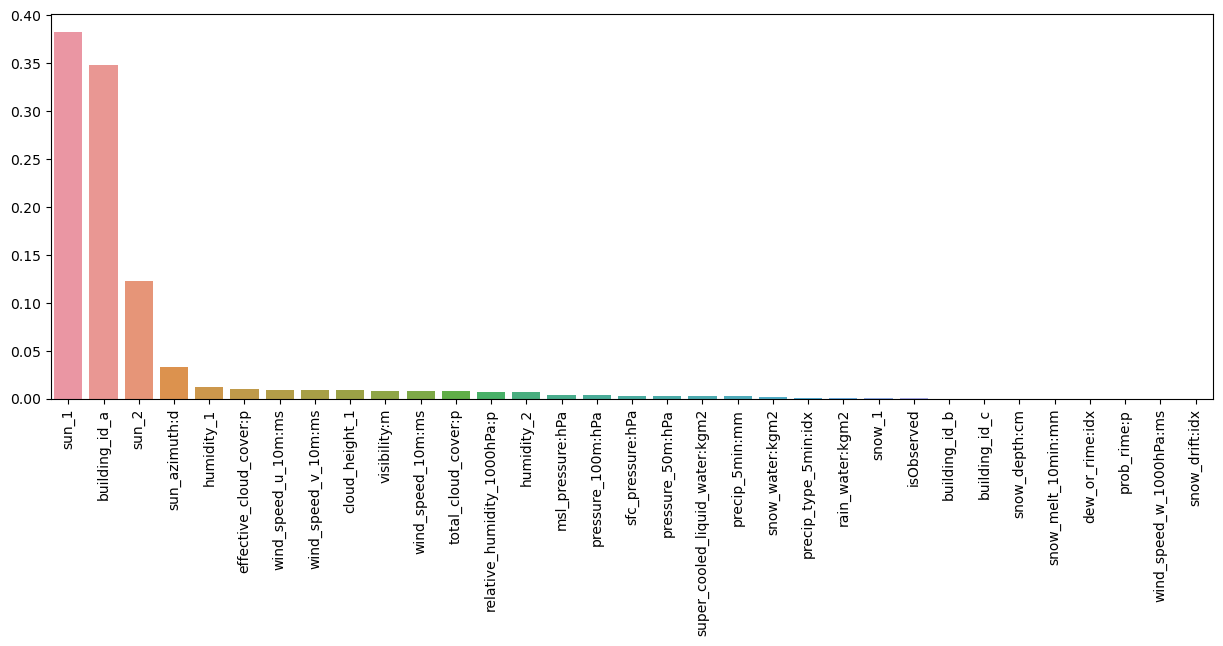

In [ ]:
f = pd.Series(random_forest.feature_importances_,
              index=all_data_pca.columns).sort_values(ascending=False)
plt.figure(figsize=(15, 5))
plt.xticks(rotation=90)
sns.barplot(x=f.index, y=f)

# save the figure to the graphs folder
plt.savefig('graphs/feature_importances.png')